In [1]:
import json
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pycocotools import mask as cocoMask
import itertools
import cv2

In [2]:
# plot distributions
window_size = 50
alpha_dist = []
beta_dist = []
with open('ellipse.p' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                alpha_list.extend(obj['alpha_ellipses'])
                beta_list.extend(obj['beta_ellipses'])
            alpha_dist.append(alpha_list)
            beta_dist.append(beta_list)
    except Exception as e:
        print(e)

Ran out of input


(array([  4.,  10.,   7.,  10.,  12.,  14.,  18.,  13.,  17.,  13.,  11.,
          5.,   7.,   3.,   4.,   2.,   0.,   1.,   1.,   2.]),
 array([  31.96346664,   45.04575748,   58.12804832,   71.21033916,
          84.29263   ,   97.37492085,  110.45721169,  123.53950253,
         136.62179337,  149.70408421,  162.78637505,  175.86866589,
         188.95095673,  202.03324757,  215.11553841,  228.19782925,
         241.28012009,  254.36241093,  267.44470177,  280.52699261,
         293.60928345]),
 <a list of 20 Patch objects>)

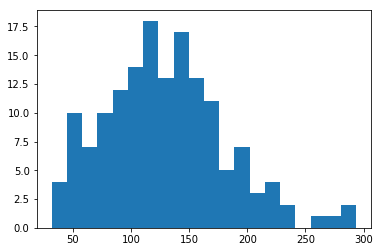

In [3]:
plt.hist([e[1][1] for e in alpha_dist[0]], bins=20) # alpha, ax1

(array([  2.,  17.,  18.,  16.,  16.,  17.,  13.,  23.,  17.,  10.,   7.,
          8.,   9.,   8.,   5.,   1.,   3.,   1.,   2.,   1.]),
 array([   1.        ,   13.07272339,   25.14544678,   37.21817017,
          49.29089355,   61.36361694,   73.43634033,   85.50906372,
          97.58178711,  109.6545105 ,  121.72723389,  133.79995728,
         145.87268066,  157.94540405,  170.01812744,  182.09085083,
         194.16357422,  206.23629761,  218.309021  ,  230.38174438,
         242.45446777]),
 <a list of 1 Patch objects>)

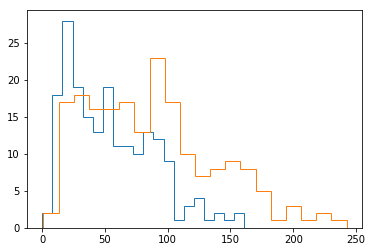

In [4]:
sel=100
lst = alpha_dist
plt.hist([e[1][0] for e in lst[sel]], bins=20, histtype='step') # beta, ax1
plt.hist([e[1][1] for e in lst[sel]], bins=20, histtype='step') # beta, ax2

(array([  90.,  147.,  282.,  251.,  197.,   99.,   51.,   28.,   15.,
           8.,    8.,    1.,    4.,    2.,    2.,    0.,    0.,    0.,
           0.,    1.]),
 array([   0.        ,    6.61611023,   13.23222046,   19.84833069,
          26.46444092,   33.08055115,   39.69666138,   46.31277161,
          52.92888184,   59.54499207,   66.16110229,   72.77721252,
          79.39332275,   86.00943298,   92.62554321,   99.24165344,
         105.85776367,  112.4738739 ,  119.08998413,  125.70609436,
         132.32220459]),
 <a list of 1 Patch objects>)

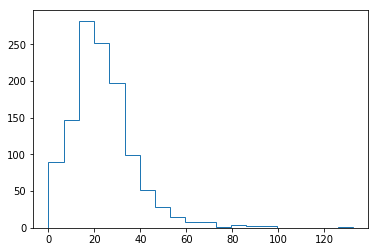

In [5]:
sel=100
plt.hist([e[1][0] for e in beta_dist[sel]], bins=20, histtype='step') # beta, ax1
#plt.hist([e[1][1] for e in beta_dist[sel]], bins=20, histtype='step') # beta, ax2

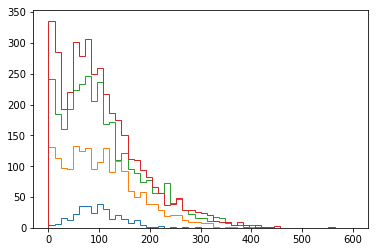

In [6]:
for i in range(10,800,200):
    plt.hist([e[1][1] for e in beta_dist[i]], bins=50, histtype='step', range=(0,600)) # beta, ax1


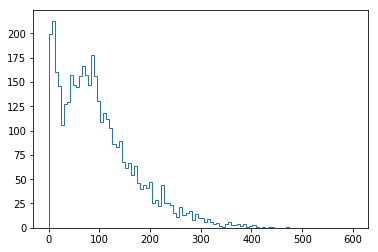

In [8]:
beta_values = plt.hist([e[1][1] for e in beta_dist[-100]], bins=100, histtype='step', range=(0,600)) # beta, ax1


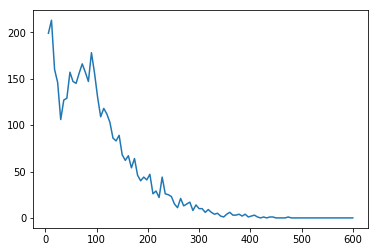

In [19]:
plt.plot(beta_values[1][1:], beta_values[0])

In [2]:
def mask2ellipse(m):
    ret = []
    if not len(m):
        return ret
    masks = cocoMask.decode(m)
    for mask in masks:
        _, contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not len(contours):
            continue
        contours = sorted(contours, reverse=True, key=cv2.contourArea)
        # only process the greatest contour
        contour = contours[0]
        if len(contour) < 5:
            continue
        e = cv2.fitEllipse(contour)
        ret.append((e[1], cv2.contourArea(contour)))
    return ret

In [8]:
# create ellipse vs area data

window_size = 120
alpha_area_ellipse_list = []
beta_area_ellipse_list = []


with open('infer_result_remove_overlapping' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                m = json.loads(obj['m'])['cls_segms']
                if not m:
                    continue
                #alpha
                alpha_list.extend(mask2ellipse(m[1]))
                beta_list.extend(mask2ellipse(m[2]))
            alpha_area_ellipse_list.append(alpha_list)
            beta_area_ellipse_list.append(beta_list)
            print(len(alpha_area_ellipse_list))
    except Exception as e:
        raise(e)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


KeyboardInterrupt: 

In [ ]:
#multi processor
from multiprocessing import Process, Pool, BoundedSemaphore

window_size = 120
alpha_area_ellipse_list = []
beta_area_ellipse_list = []

def process_task(lock, t, load_list, alpha_area_ellipse_list, beta_area_ellipse_list):
    #only process one time point
    print(t)
    alpha_list = []
    beta_list = []
    for loaded in load_list:
        alpha_list.extend(mask2ellipse(loaded[1]))
        beta_list.extend(mask2ellipse(loaded[2]))
    alpha_area_ellipse_list.append([t,alpha_list])
    alpha_area_ellipse_list.append([t,beta_list])
    lock.release()
with open('infer_result_remove_overlapping' ,'rb') as input_file:
    load_list = []
    t_list = []
    pool = Pool(processes=4) 
    lock = BoundedSemaphore(3)
    while True:
        try:
            for i in range(window_size):
                obj = pickle.load(input_file)
                m = json.loads(obj['m'])['cls_segms']
                try:
                    f = int(obj['f'].split('.')[0])
                except:
                    continue
                t_list.append(f)
                if not m:
                    continue
                load_list.append(m)
            t = np.mean(t_list)
            print ("Prepared an object")
            
            lock.acquire()
            pool.apply_async(process_task, (lock, t, load_list, alpha_area_ellipse_list, beta_area_ellipse_list))
        except Exception as e:
            raise(e)

Prepared an object
Prepared an object
Prepared an object
Prepared an object


In [4]:
pool.terminate()

In [5]:
alpha_area_ellipse_list

[]